# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name='Reacher-20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agent(s). Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agent(s). Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
import numpy as np
import random
from collections import namedtuple, deque
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import numpy as np
import random
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device {}'.format(device))

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)    
    
class Actor_Critic(nn.Module):
    
    def __init__(self, state_size, action_size, hidden=[512,512,512]):
        super(Actor_Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])
        self.fc4 = nn.Linear(hidden[2], action_size)
        self.fc5 = nn.Linear(hidden[2], 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        action = F.tanh(self.fc4(x))
        value = self.fc5(x)
        return action, value

Using device cpu


In [7]:
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import math
from collections import deque
from torch.utils.data import Dataset, TensorDataset, DataLoader

class PPO_Agent:
    def __init__(self, env, lr=0.001, beta=0, learning_time=3, std=0.5, eps=0.2, tau=0.995, batch_size=128):
        
        #Initialize environment
        brain_name = env.brain_names[0]
        brain = env.brains[brain_name]
        env_info = env.reset(train_mode=True)[brain_name]
        num_agents = len(env_info.agents)
        action_size = brain.vector_action_space_size
        states = env_info.vector_observations
        state_size = states.shape[1]
        self.env = env
        
        #Initialize some hyper parameters of agent
        self.lr = lr
        self.learning_time = learning_time
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.gamma = 0.99
        self.batch_size = batch_size
        self.beta = beta#parameter for entropy panelty
        self.eps = eps#parameter for clip
        self.tau = tau#parameter for GAE
        
        #Networks and optimizers
        self.network = Actor_Critic(self.state_size, self.action_size).to(device)
        self.optimizer = optim.Adam(self.network.parameters(),lr=self.lr)
        
        #About noise
        self.std = std
        self.mean = torch.zeros([self.num_agents, self.action_size], dtype=torch.float32)
        
    def act(self, states, std):
        with torch.no_grad():
            states = torch.tensor(states, dtype=torch.float).to(device)
            actions_original, _ = self.network(states)
            noise = torch.distributions.Normal(self.mean, std).sample().to(device)
            actions = actions_original + noise
            actions = torch.clamp(actions, -1, 1)
            log_probs = torch.distributions.Normal(actions_original, std).log_prob(actions)
            log_probs = log_probs.sum(dim=1, keepdim=True).detach().cpu().numpy()
            actions = actions.detach().cpu().numpy()
        return actions, log_probs
    
    def learn(self, states, actions, log_probs, dones, Advantages, Returns):
        '''
        This functions calculates the clipped surrogate function and do one step update to the action network
        And then the critic network will be updated
        The inputs are all lists of tensors. They are already sent to device before into the list
        '''
        
        #Generate dataset for getting small batches
        mydata = TensorDataset(states, actions, log_probs, dones, Advantages, Returns)
        Loader = DataLoader(mydata, batch_size = self.batch_size, shuffle = True)
        
        for i in range(self.learning_time):
            for sampled_states, sampled_actions, sampled_log_probs, sampled_dones, sampled_advantages, sampled_returns in iter(Loader):
                new_actions, V = self.network(sampled_states)
                new_log_probs = torch.distributions.Normal(new_actions, self.std).log_prob(sampled_actions)
                new_log_probs = new_log_probs.sum(dim=1, keepdim=True)
                ratio = (new_log_probs - sampled_log_probs).exp()
                
                Actor_Loss = -torch.min(input=ratio*sampled_advantages, other=torch.clamp(ratio, 1-self.eps, 1+self.eps)*sampled_advantages).mean()
                Critic_Loss = 0.5*(V-sampled_returns).pow(2).mean()
                Loss = Actor_Loss+Critic_Loss
                self.optimizer.zero_grad()
                Loss.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 5)
                self.optimizer.step()
            
    def train(self, n_episode, standardlize='row'):
        '''
        This function do the training part of the agent. The procedure is like:
            1. initialize environment
            2. Go through a whole episode, recode all states, actions, log_probs, rewards and dones information
            3. call learn function to update the networks
            4. repeat 2-3 for n_episode times.
        '''
        all_rewards = []
        brain_name = self.env.brain_names[0]
        score_window = deque(maxlen=100)
        
        standardlize = standardlize.lower()
        if standardlize not in ['row','whole']:
            print('Standarlization in row or as a whole. Input not supported. Use row instead')
            standardlize = 'row'
        
        for i in range(1, n_episode+1):
            #initialize environment
            episodic_reward = np.zeros(self.num_agents)
            env_info = self.env.reset(train_mode=True)[brain_name]
            states_history = []
            actions_history = []
            rewards_history = []
            log_probs_history = []
            dones_history = []
            states = env_info.vector_observations
            actions, log_probs = self.act(states, self.std)
            
            while True:
                states_history.append(torch.tensor(states, dtype=torch.float).to(device))
                actions_history.append(torch.tensor(actions, dtype=torch.float).to(device))
                log_probs_history.append(torch.tensor(log_probs, dtype=torch.float).to(device))#Save as columns
                env_info = self.env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                dones = torch.tensor(env_info.local_done, dtype=torch.float).view(-1,1).to(device)
                rewards = torch.tensor(env_info.rewards, dtype=torch.float).view(-1,1).to(device)
                episodic_reward += np.array(env_info.rewards)
                rewards_history.append(rewards)
                dones_history.append(dones)
                
                states = next_states
                actions, log_probs = self.act(states, self.std)
            
                if any(dones):
                    break
                    
            states_history.append(torch.tensor(states, dtype=torch.float).to(device))
            Advantages = []
            advantage = 0
            Returns = []
            returns = 0
            #Calculate advantages
            for j in reversed(range(len(states_history)-1)):
                returns = rewards_history[j] + (1-dones_history[j])*returns*self.gamma
                Returns.append(returns.view(-1))
                states = states_history[j]
                next_states = states_history[j+1]
                _, value = self.network(states)
                _, next_value = self.network(next_states)
                delta = rewards_history[j] + (1-dones_history[j])*self.gamma*next_value.detach() - value.detach()
                advantage = advantage*self.gamma*self.tau*(1-dones_history[j]) + delta
                Advantages.append(advantage.view(-1))
            Advantages.reverse()
            Advantages = torch.stack(Advantages).detach().to(device)
            if standardlize == 'row':
                Advantages = (Advantages - Advantages.mean(dim=1 ,keepdim=True))/Advantages.std(dim=1, keepdim=True)
            else:
                Advantages = (Advantages - Advantages.mean())/Advantages.std()
            Advantages = Advantages.view(-1,1)
            Returns.reverse()
            Returns = torch.stack(Returns).detach().to(device)
            Returns = Returns.view(-1,1)
            
            states_history = torch.cat(states_history[:-1], 0)
            actions_history = torch.cat(actions_history, 0)
            log_probs_history = torch.cat(log_probs_history, 0)
            dones_history = torch.cat(dones_history, 0)
            
            self.learn(states_history, actions_history, log_probs_history, dones_history, Advantages, Returns)
            
            score_window.append(np.mean(episodic_reward))
            all_rewards.append(episodic_reward)
            print('\rEpisode {}. Total score for this episode: {:.4f}, average score {:.4f}'.format(i, np.mean(episodic_reward), np.mean(score_window)),end='')
            if i % 100 == 0:
                print(' ')
        
        np.save('PPO_rewards.npy',np.array(all_rewards))
        self.network.cpu()
        torch.save(self.network.state_dict(),'PPO_checkpoint.pth')
        return all_rewards

In [8]:
agent = PPO_Agent(env=env, batch_size=512)
rewards = agent.train(200, standardlize='whole')

Episode 100. Total score for this episode: 10.6170, average score 4.7396 
Episode 200. Total score for this episode: 15.1835, average score 13.3831 


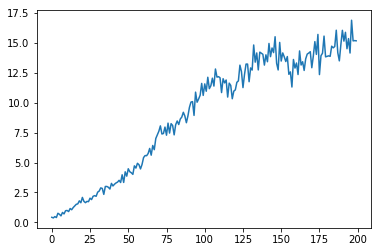

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

In [10]:
agent = PPO_Agent(env=env, batch_size=512)
rewards = agent.train(200, standardlize='row')

Episode 100. Total score for this episode: 12.9965, average score 5.3944 
Episode 200. Total score for this episode: 19.5680, average score 20.1683 


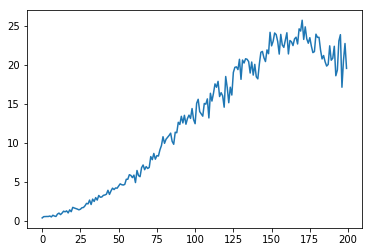

In [11]:
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

In [12]:
agent = PPO_Agent(env=env, batch_size=512, lr=0.0001)
rewards = agent.train(200, standardlize='whole')

Episode 100. Total score for this episode: 14.7345, average score 6.4478 
Episode 200. Total score for this episode: 28.6655, average score 22.3704 


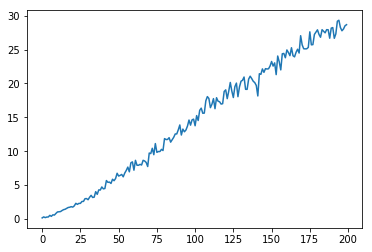

In [13]:
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

In [14]:
agent = PPO_Agent(env=env, batch_size=512, lr=0.0001)
rewards = agent.train(200, standardlize='row')

Episode 100. Total score for this episode: 17.9580, average score 7.1687 
Episode 200. Total score for this episode: 31.2465, average score 25.7263 


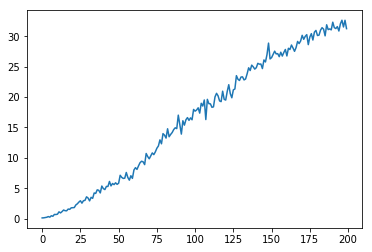

In [15]:
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

In [16]:
agent = PPO_Agent(env=env, batch_size=256, lr=0.0001)
rewards = agent.train(200, standardlize='row')

Episode 100. Total score for this episode: 16.1860, average score 7.1543 
Episode 200. Total score for this episode: 22.2790, average score 19.4021 


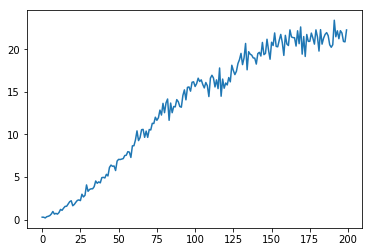

In [17]:
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()